# Page Detection
And playing around with OpenCV

In [1]:
import cv2 as cv
import numpy as np
import os.path
import pandas as pd
from helpers.features import read_offset_csv, preprocess, transform_offsets_to_paths, show_image
from helpers.features import detect_keypoints_and_descriptors
from helpers.features import detect_keypoints_and_descriptors_orb, detect_keypoints_and_descriptors_akaze, detect_keypoints_and_descriptors_brisk
from helpers.features import precision_recall_curves, intersection_df, cross_match

## Step 1: Reading in Images

In [2]:
shuuchin1 = read_offset_csv("annotations/shuuchinbukan-1.csv")

This is the raw offset table. With this one can get matching images.

### Converting the offset table to pathnames

In [3]:
shuuchin1_paths = transform_offsets_to_paths(shuuchin1)

These are two simple pages for comparion. They should be relatively easy.

It's page 5 of the bukan' with IDs *200019525* and *200019527*.

In [4]:
img1 = cv.imread(shuuchin1_paths["200019525"][5])
img1 = preprocess(img1)
img2 = cv.imread(shuuchin1_paths["200019527"][5])
img2 = preprocess(img2)

## Corner Detection

Doing some tutorials from <https://docs.opencv.org/4.1.1/db/d27/tutorial_py_table_of_contents_feature2d.html>.

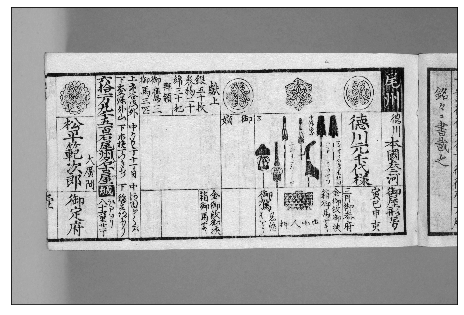

In [5]:
show_image(img1, (8, 8))

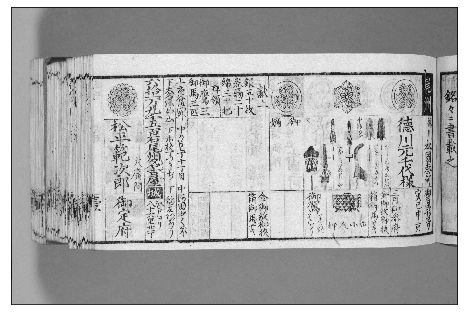

In [6]:
show_image(img2, (8, 8))

### Harris Corner Detection

<https://docs.opencv.org/4.1.1/dc/d0d/tutorial_py_features_harris.html>

In [7]:
def harris_corner_detection(img):
    corners = cv.cornerHarris(img, 2, 3, 0.04)
    corners = cv.dilate(corners, None)
    output = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    output[corners > 0.09 * corners.max()] = [255, 0, 0]
    return output

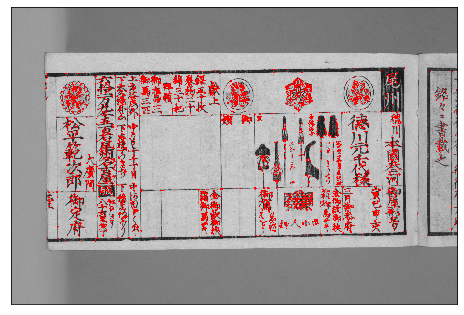

In [8]:
show_image(harris_corner_detection(img1))

Result: These are lots of corners. It doesn't make sense to track all of them. But might just be a thresholding problem.

Let's take a look at the improved algorithms.

### Shi-Tomasi Corner Detector (Good Features to Track)

<https://docs.opencv.org/4.1.1/d4/d8c/tutorial_py_shi_tomasi.html>

In [9]:
def shi_thomasi_corner_detection(img):
    corners = cv.goodFeaturesToTrack(img, 25, 0.01, 10)
    corners = np.int0(corners)
    output = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    for i in corners:
        x, y = i.ravel()
        cv.circle(output, (x, y), 5, [255, 0, 0], cv.FILLED)
    return output, corners

In [10]:
def compare_shi_thomasi_corners(img, corners1, corners2):
    output = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    for i in corners1:
        x, y = i.ravel()
        cv.circle(output, (x, y), 6, [255, 0, 0], cv.FILLED)
    for i in corners2:
        x, y = i.ravel()
        cv.circle(output, (x, y), 5, [0, 0, 255], 2)
    return output

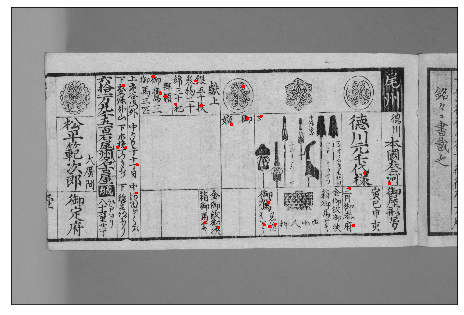

In [11]:
show_image(shi_thomasi_corner_detection(img1)[0], (8, 8))

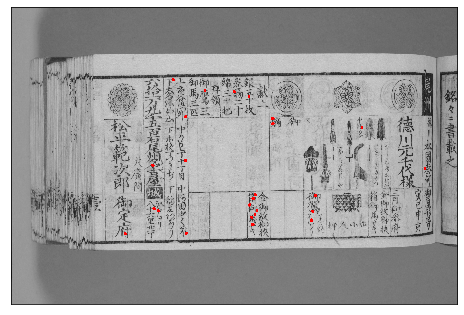

In [12]:
show_image(shi_thomasi_corner_detection(img2)[0], (8, 8))

Result: These are some nice and simple features. But they don't really match, do they? Even though I used the same parameters.

Might be better for *tracking*.

### ORB

<https://docs.opencv.org/4.1.1/d1/d89/tutorial_py_orb.html>

In [13]:
def orb_features(img):
    orb = cv.ORB_create()
    keypoints = orb.detect(img, None)
    keypoints, descriptors = orb.compute(img, keypoints)
    output = cv.drawKeypoints(img, keypoints, None, color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)
    return output

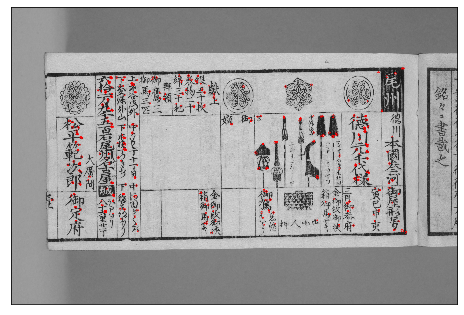

In [14]:
show_image(orb_features(img1), (8, 8))

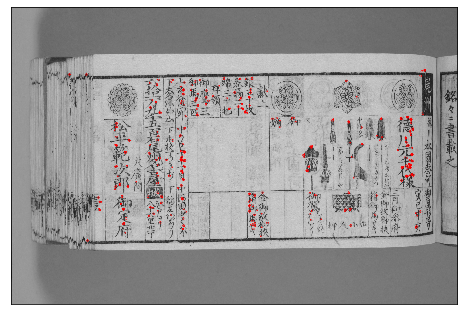

In [15]:
show_image(orb_features(img2), (8, 8))

### Feature Matching

<https://docs.opencv.org/4.1.1/dc/dc3/tutorial_py_matcher.html>

Create a `results` directory where we can save all the intermediate results of the matchings.

In [16]:
try:
    os.mkdir("results")
except FileExistsError:
    print("results directory already exists")

results directory already exists


In [17]:
orb = cv.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

In [18]:
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x:x.distance)

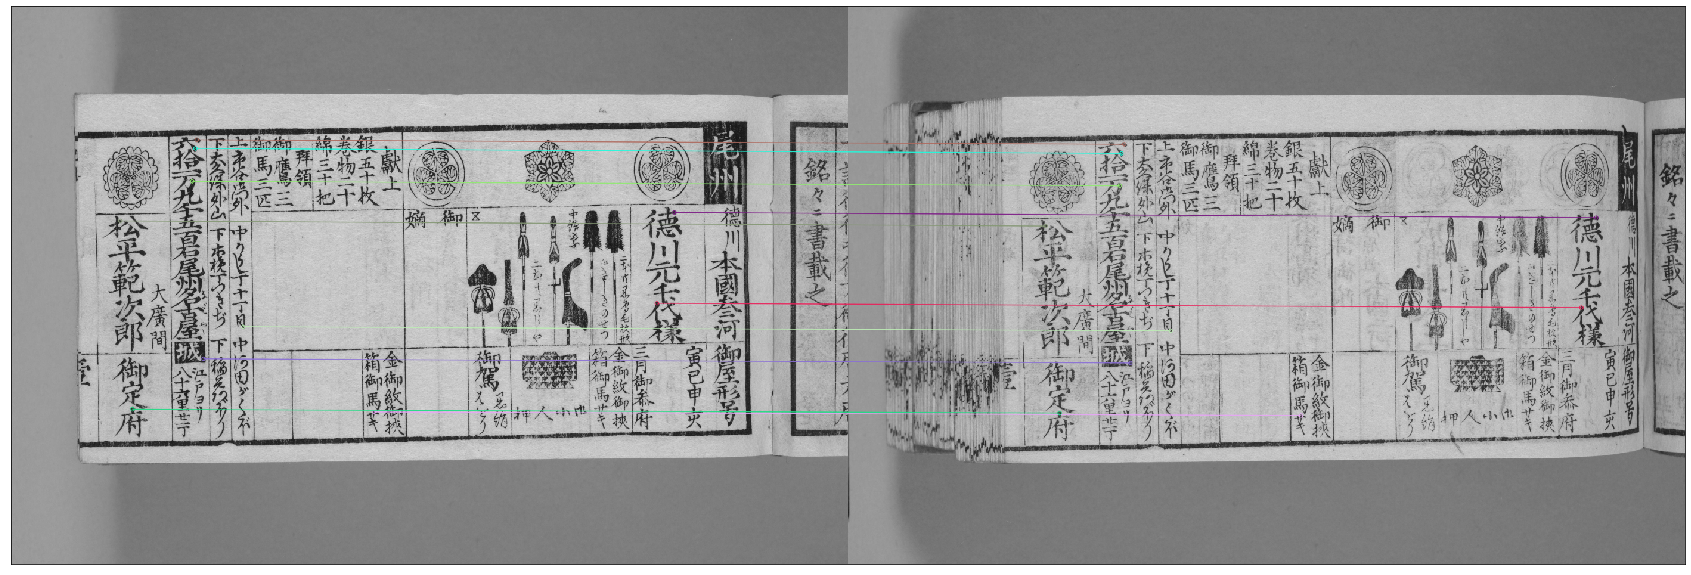

In [19]:
match_image = cv.drawMatches(img1, keypoints1,
                             img2, keypoints2,
                             matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show_image(match_image, (30, 30))
#cv.imwrite("matches.jpg", match_image)

In [20]:
nr_good_matches = int(len(matches) * 0.2)
good_matches = matches[:nr_good_matches]

In [21]:
points1 = np.array([keypoints1[x.queryIdx].pt for x in good_matches])
points2 = np.array([keypoints2[x.trainIdx].pt for x in good_matches])

In [22]:
h, mask = cv.findHomography(points1, points2, cv.RANSAC)

In [23]:
height, width = img2.shape
aligned_image = cv.warpPerspective(img1, h, (width, height))

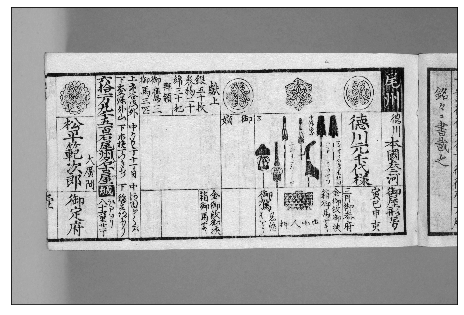

In [24]:
show_image(img1)

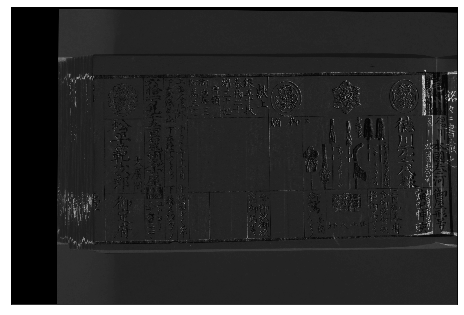

In [25]:
show_image(aligned_image / img2)

### ORB

In [26]:
if os.path.exists("results/orb_matches.h5"):
    matches_df = pd.read_hdf("results/orb_matches.h5", "orb")
else:
    detect_tims_s, (shuuchin1_keypoints, shuuchin1_descriptors) = detect_keypoints_and_descriptors_orb(shuuchin1_paths)
    print("Getting all descriptors took", detect_tims_s, "seconds.")
    match_time_s, matches_df = cross_match(shuuchin1_descriptors)
    print("Getting all the cross matches took", match_time_s, "seconds.")
    matches_df.to_hdf("results/orb_matches.h5", key="orb", mode="w", complevel=9)

In [27]:
pr_results = precision_recall_curves(matches_df, 11, 36, 3)

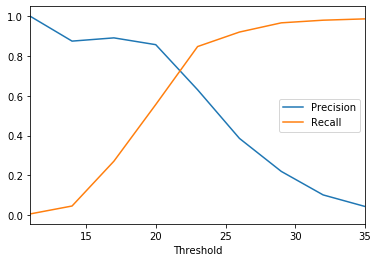

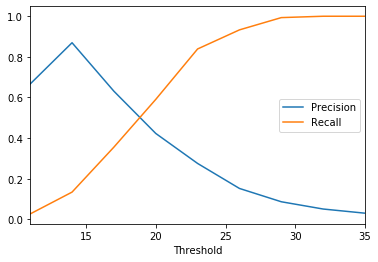

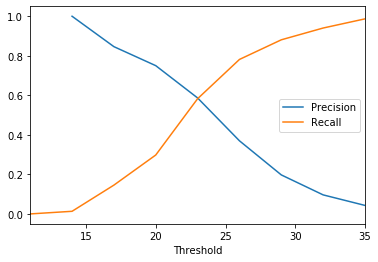

In [28]:
for book1, book2, _ in pr_results.sample(3).index:
    pr_results.loc[book1, book2].plot()

### AKAZE UPRIGHT

In [29]:
if os.path.exists("results/akaze_matches.h5"):
    matches_df_akaze = pd.read_hdf("results/akaze_matches.h5", "akaze")
else:
    detect_time_s_akaze, (shuuchin1_keypoints_akaze, shuuchin1_descriptors_akaze) =  detect_keypoints_and_descriptors_akaze(shuuchin1_paths)
    print("Getting all descriptors took", detect_time_s_akaze, "seconds.")
    match_time_s_akaze, matches_df_akaze = cross_match(shuuchin1_descriptors_akaze)
    print("Getting all the cross matches took", match_time_s_akaze, "seconds.")
    matches_df_akaze.to_hdf("results/akaze_matches.h5", key="akaze", mode="w", complevel=9)

In [30]:
pr_results_akaze = precision_recall_curves(matches_df_akaze, 26, 51, 3)

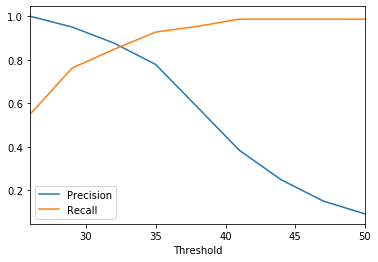

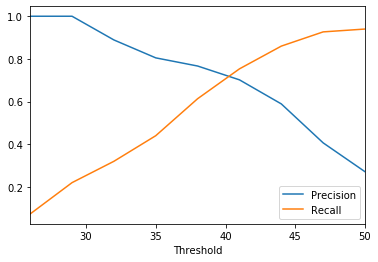

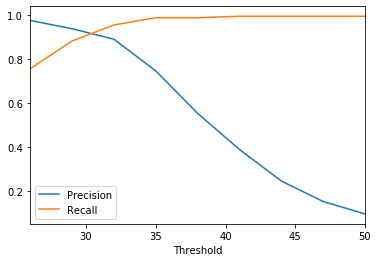

In [31]:
for book1, book2, _ in pr_results_akaze.sample(3).index:
    pr_results_akaze.loc[book1, book2].plot()

### AZAZE

In [32]:
if os.path.exists("results/akaze0_matches.h5"):
    matches_df_akaze0 = pd.read_hdf("results/akaze0_matches.h5", "akaze0")
else:
    akaze = cv.AKAZE_create(descriptor_size=0, threshold=0.008)
    detect_time_s_akaze0, (shuuchin1_keypoints_akaze0, shuuchin1_descriptors_akaze0) =  detect_keypoints_and_descriptors(shuuchin1_paths, akaze)
    print("Getting all descriptors took", detect_time_s_akaze0, "seconds.")
    match_time_s_akaze0, matches_df_akaze0 = cross_match(shuuchin1_descriptors_akaze0)
    print("Getting all the cross matches took", match_time_s_akaze0, "seconds.")
    matches_df_akaze0.to_hdf("results/akaze0_matches.h5", key="akaze0", mode="w", complevel=9)

In [33]:
pr_results_akaze0 = precision_recall_curves(matches_df_akaze0, 26, 51, 3)

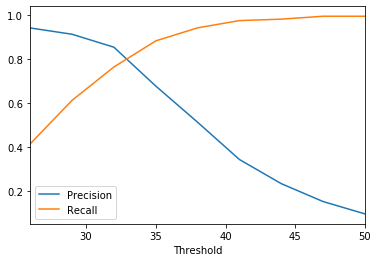

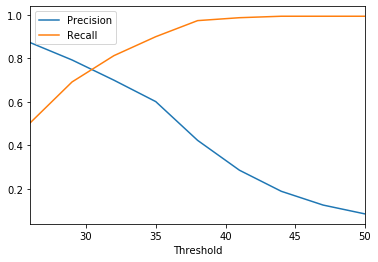

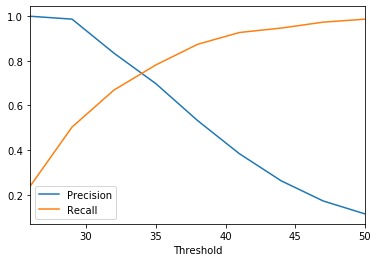

In [34]:
for book1, book2, _ in pr_results_akaze0.sample(3).index:
    pr_results_akaze0.loc[book1, book2].plot()

### BRISK

In [35]:
if os.path.exists("results/brisk_matches.h5"):
    matches_df_brisk = pd.read_hdf("results/brisk_matches.h5", "brisk")
else:
    detect_time_s_brisk, (shuuchin1_keypoints_brisk, shuuchin1_descriptors_brisk) = detect_keypoints_and_descriptors_brisk(shuuchin1_paths)
    print("Getting all descriptors took", detect_time_s_brisk, "seconds.")
    match_time_s_brisk, matches_df_brisk = cross_match(shuuchin1_descriptors_brisk)
    print("Getting all the cross matches took", match_time_s_brisk, "seconds.")
    matches_df_brisk.to_hdf("results/brisk_matches.h5", key="brisk", mode="w", complevel=9)

In [36]:
pr_results_brisk = precision_recall_curves(matches_df_brisk, 41, 76, 3)

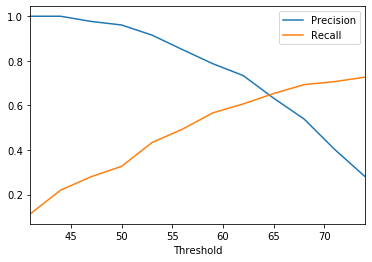

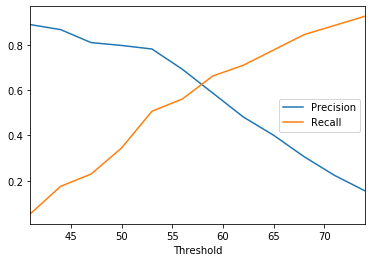

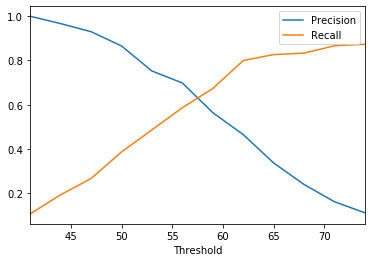

In [37]:
for book1, book2, _ in pr_results_brisk.sample(3).index:
    pr_results_brisk.loc[book1, book2].plot()

### SIFT

Getting all descriptors took 687.8391989000002 seconds.


Getting all the cross matches took 1143.4415156000005 seconds.


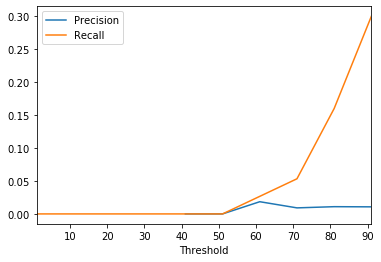

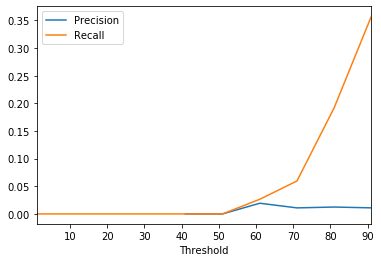

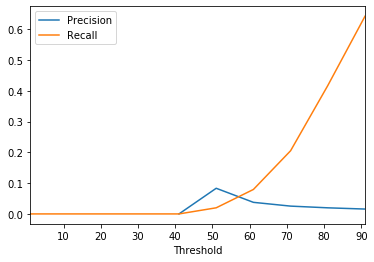

In [38]:
try:
    if os.path.exists("results/sift_matches.h5"):
        matches_df_sift = pd.read_hdf("results/sift_matches.h5", "sift")
    else:
        sift = cv.xfeatures2d.SIFT_create(nfeatures=250)
        detect_time_s_sift, (shuuchin1_keypoints_sift, shuuchin1_descriptors_sift) =  detect_keypoints_and_descriptors(shuuchin1_paths, sift)
        print("Getting all descriptors took", detect_time_s_sift, "seconds.")
        match_time_s_sift, matches_df_sift = cross_match(shuuchin1_descriptors_sift, norm_type=cv.NORM_L2)
        print("Getting all the cross matches took", match_time_s_sift, "seconds.")
        matches_df_sift.to_hdf("results/sift_matches.h5", key="sift", mode="w", complevel=9)
    pr_results_sift = precision_recall_curves(matches_df_sift, 1, 101, 10)
    for book1, book2, _ in pr_results_sift.sample(3).index:
        pr_results_sift.loc[book1, book2].plot()
except AttributeError as e:
    print("It seems the xfeatures module does not exists. You need to recompile OpenCV with nonfree algorithms to get SIFT and SURF.")
    print(e)

### SURF

Getting all descriptors took 388.3555203999995 seconds.


Getting all the cross matches took 438.6003225000004 seconds.


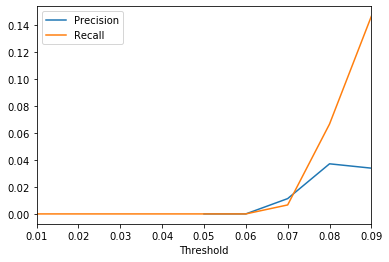

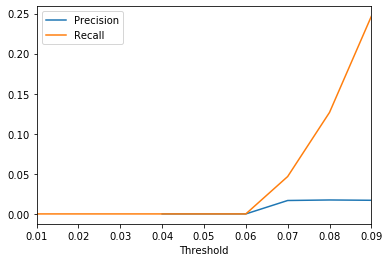

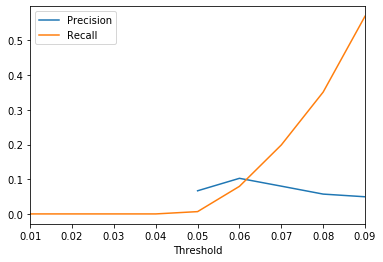

In [39]:
try:
    if os.path.exists("results/surf0_matches.h5"):
        matches_df_surf0 = pd.read_hdf("results/surf0_matches.h5", "surf0")
    else:
        surf0 = cv.xfeatures2d.SURF_create(upright=False, hessianThreshold=10000)
        detect_time_s_surf0, (shuuchin1_keypoints_surf0, shuuchin1_descriptors_surf0) =  detect_keypoints_and_descriptors(shuuchin1_paths, surf0)
        print("Getting all descriptors took", detect_time_s_surf0, "seconds.")
        match_time_s_surf0, matches_df_surf0 = cross_match(shuuchin1_descriptors_surf0, norm_type=cv.NORM_L2)
        print("Getting all the cross matches took", match_time_s_surf0, "seconds.")
        matches_df_surf0.to_hdf("results/surf0_matches.h5", key="surf0", mode="w", complevel=9)
    pr_results_surf0 = precision_recall_curves(matches_df_surf0, 0.01, 0.1, 0.01)
    for book1, book2, _ in pr_results_surf0.sample(3).index:
        pr_results_surf0.loc[book1, book2].plot()
except AttributeError as e:
    print("It seems the xfeatures module does not exists. You need to recompile OpenCV with nonfree algorithms to get SIFT and SURF.")
    print(e)

### SURF UPRIGHT

Getting all descriptors took 400.9616865000007 seconds.


Getting all the cross matches took 434.80307540000103 seconds.


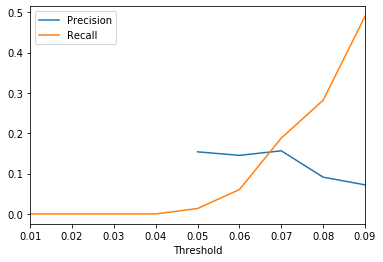

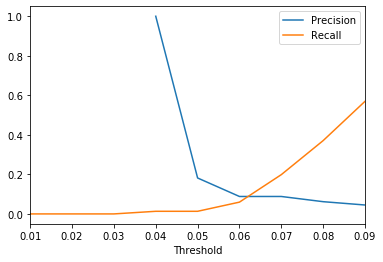

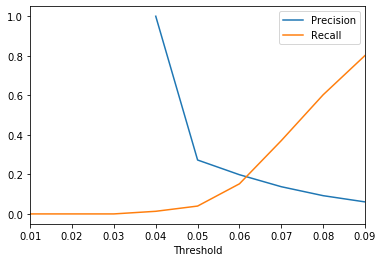

In [40]:
try:
    if os.path.exists("results/surf_matches.h5"):
        matches_df_surf0 = pd.read_hdf("results/surf_matches.h5", "surf")
    else:
        surf = cv.xfeatures2d.SURF_create(upright=True, hessianThreshold=10000)
        detect_time_s_surf, (shuuchin1_keypoints_surf, shuuchin1_descriptors_surf) =  detect_keypoints_and_descriptors(shuuchin1_paths, surf)
        print("Getting all descriptors took", detect_time_s_surf, "seconds.")
        match_time_s_surf, matches_df_surf = cross_match(shuuchin1_descriptors_surf, norm_type=cv.NORM_L2)
        print("Getting all the cross matches took", match_time_s_surf, "seconds.")
        matches_df_surf.to_hdf("results/surf_matches.h5", key="surf", mode="w", complevel=9)
    pr_results_surf = precision_recall_curves(matches_df_surf, 0.01, 0.1, 0.01)
    for book1, book2, _ in pr_results_surf.sample(3).index:
        pr_results_surf.loc[book1, book2].plot()
except AttributeError as e:
    print("It seems the xfeatures module does not exists. You need to recompile OpenCV with nonfree algorithms to get SIFT and SURF.")
    print(e)

### Precision-Recall Intersection

In [41]:
orb_intersections = intersection_df(pr_results)
akaze_intersections = intersection_df(pr_results_akaze)
akaze0_intersections = intersection_df(pr_results_akaze0)
brisk_intersections = intersection_df(pr_results_brisk)

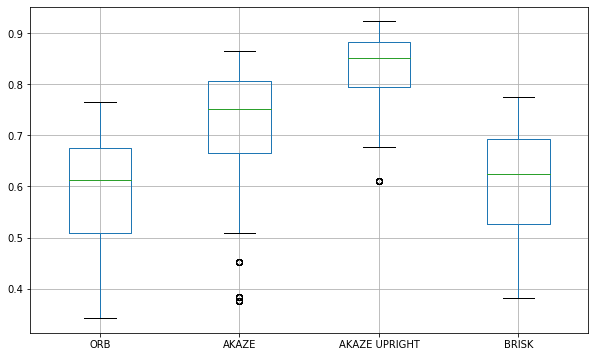

In [42]:
plot = pd.DataFrame(
    [orb_intersections["Value"].values,
     akaze0_intersections["Value"].values,
     akaze_intersections["Value"].values,
     brisk_intersections["Value"].values],
    index=["ORB", "AKAZE", "AKAZE UPRIGHT", "BRISK"]
).T.boxplot(figsize=(10,6))

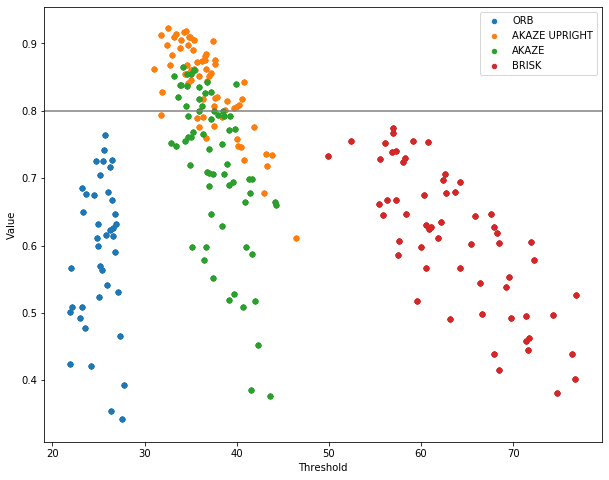

In [43]:
ax = orb_intersections.plot.scatter(x='Threshold', y='Value', color='#1f77b4', label='ORB', figsize=(10,8))
akaze_intersections.plot.scatter(x='Threshold', y='Value', color='#ff7f0e', label='AKAZE UPRIGHT', ax=ax)
akaze0_intersections.plot.scatter(x='Threshold', y='Value', color='#2ca02c', label='AKAZE', ax=ax)
brisk_intersections.plot.scatter(x='Threshold', y='Value', color='#d62728', label='BRISK', ax=ax)
plot = ax.axhline(0.8, color="grey")
#fig = plot.get_figure()
#fig.savefig("output.svg")